## Lista 4 - Questão 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
plt.style.use('../est.mplstyle')

In [4]:
colors = ["#003f5c", "#58508d", "#bc5090", "#ff6361", "#ffa600"]

**Espaço de estados**

In [5]:
S = np.arange(0, 5, 1)

**Matriz de Transição**

In [6]:
P = np.array([[0, 0.5, 0.5, 0, 0],
              [0.5, 0, 0.5, 0, 0],
              [1/3, 1/3, 0, 1/3, 0],
              [0, 0, 0.5, 0, 0.5],
              [0.5, 0, 0, 0.5, 0]])

**Função de atualização**

In [7]:
def update_function(i, u, transition_matrix=P):
    state = np.digitize(u, transition_matrix.cumsum(axis=1)[i, :]).item()
    return state    

**Função de inicialização**

In [8]:
def init_function(u, distribution):
    state = np.digitize(u, distribution.cumsum(axis=0))
    return state

### Letra b)

In [9]:
N_ITER = 20

**Simulação de $(X_n)_{n \ge 0}$ e $(X'_n)_{n \ge 0}$**

In [10]:
def simulate(unif_sample, init_function, update_function):
    n_iter = unif_sample.shape[0] 
    chain = np.zeros(n_iter, dtype=np.int32) 
    chain[0] = init_function(unif_sample[0])
    for i in range(1, n_iter):
        state = update_function(chain[i-1], unif_sample[i])
        chain[i] = state
    return chain        

**Realização da cadeia $(X_n)_{n \ge 0}$**

Distribuição inicial: uniforme nos estados da cadeia.

In [11]:
pi0 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

Inicialização

In [12]:
init_function_pi0 = lambda u: init_function(u, distribution=pi0)

Amostragem de $U_i \sim \mathsf{Unif}(0,1)$

In [13]:
u = np.random.random(size=N_ITER)

Simulação

In [14]:
x_n = simulate(u, init_function_pi0, update_function)

**Realização da cadeia $(X'_n)_{n \ge 0}$**

Distribuição inicial: estacionária.

In [15]:
pi = np.array([22/87, 20/87, 9/29, 4/29, 2/29])

Inicialização

In [16]:
init_function_pi = lambda u: init_function(u, distribution=pi)

Amostragem de $U'_i \sim \mathsf{Unif}(0,1)$ independentes de $U_j$

In [17]:
up = np.random.random(size=N_ITER)

Simulação

In [18]:
xp_n = simulate(up, init_function_pi, update_function)

**Construção de $(X''_n)_{n \ge 0}$**

In [19]:
def simulate_pp(x_n, xp_n):
    index_match = np.where(x_n == xp_n)[0]
    xpp_n = x_n.copy()
    if index_match.size > 0:
        meeting_time = index_match[0]
        xpp_n[meeting_time:] = xp_n[meeting_time:]
    return xpp_n

**Realização de $(X''_n)_{n \ge 0}$**

In [20]:
xpp_n = simulate_pp(x_n, xp_n)

#### Visualização

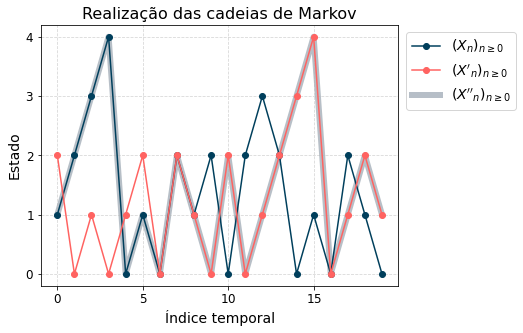

In [21]:
plt.plot(x_n, 'o-', color=colors[0], label=r"$(X_n)_{n \geq 0}$")
plt.plot(xp_n, 'o-', color=colors[3], label=r"$({X'}_n)_{n \geq 0}$")
plt.plot(xpp_n, '-', lw=6, alpha=0.5, zorder=-1, color='slategray', label=r"$({X''}_n)_{n \geq 0}$")
plt.title("Realização das cadeias de Markov")
plt.xlabel("Índice temporal")
plt.ylabel("Estado")
plt.ticklabel_format(axis='x', style='plain')
plt.xticks(list(range(0, 20, 5)))
plt.yticks(list(range(0, 5, 1)))
plt.grid(alpha=0.5, linestyle='--')
plt.legend(bbox_to_anchor=(1.35, 1.0))
plt.savefig('../figures/l4/chain-realization.pdf', bbox_inches='tight')
plt.show()

### Letra c)

**Função de estimação do tempo de encontro**

Simulamos até `n_iter`, obtemos o tempo de encontro. Repetimos para `n_chains` realizações da cadeia e tomamos a distribuição empíricas dos tempos de encontro obtidos.

In [22]:
def estimate_meeting_time_cdf(n_chains=4000, n_iter=100):
    meeting_times = np.zeros(n_chains, dtype=np.int32)
    for i in range(n_chains):
        u = np.random.random(size=n_iter)
        up = np.random.random(size=n_iter)
        x_n = simulate(u, init_function_pi0, update_function)
        xp_n = simulate(up, init_function_pi, update_function)
        index_match = np.where(x_n == xp_n)[0]
        if index_match.size > 0:
            meeting_time = index_match[0]
            meeting_times[i] = meeting_time
    meeting_times_cdf = np.cumsum(np.bincount(meeting_times)/n_chains)
    return meeting_times_cdf

In [23]:
mt_cdf_estimate = estimate_meeting_time_cdf()

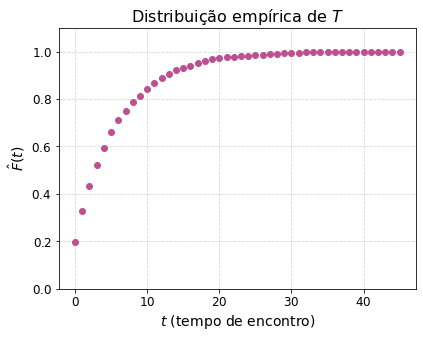

In [24]:
plt.plot(mt_cdf_estimate, 'o', color=colors[2])
plt.title(r"Distribuição empírica de $T$")
plt.xlabel(r"$t$ (tempo de encontro)")
plt.ylabel(r"$\hat{F}(t)$")
plt.grid(alpha=0.5, linestyle='--')
plt.ylim(0, 1.1)
plt.savefig('../figures/l4/empirical-dist.pdf', bbox_inches='tight')
plt.show()

### Letra d)

**Função de estimação da distância de variação total**

Simulamos até `n_iter`. Verificamos se a última entrada simulada da cadeia $(X''_n)_{n \ge 0}$ é diferente da entrada correspondente em $(X'_n)_{n \ge 0}$. Se for diferente, aumentamos um contador. Realizamos esse procedimento para `n_chains` realizações destas cadeias. A estimativa da dist. de variação total é a proporção de cadeias em `n_chains` que tinham as últimas entradas simuladas distintas.

In [25]:
def estimate_total_variation(n_chains=2000, n_iter=40):
    counter = 0
    for i in range(n_chains):
        u = np.random.random(size=n_iter)
        up = np.random.random(size=n_iter)
        x_n = simulate(u, init_function_pi0, update_function)
        xp_n = simulate(up, init_function_pi, update_function)
        xpp_n = simulate_pp(x_n, xp_n)
        if xpp_n[-1] != xp_n[-1]:
            counter += 1
    return counter/n_chains

Para $n=10, 20, 50, 100$

In [26]:
estimate_total_variation(n_iter=10)

0.1665

In [27]:
estimate_total_variation(n_iter=20)

0.029

In [28]:
estimate_total_variation(n_iter=50)

0.0

In [29]:
estimate_total_variation(n_iter=100)

0.0

#### Visualização

In [30]:
n_iter_range = np.arange(1, 40, 1)

In [31]:
tv_dist_range = []
for i in n_iter_range:
    tv_dist_range.append(estimate_total_variation(n_chains=4000, n_iter=i))

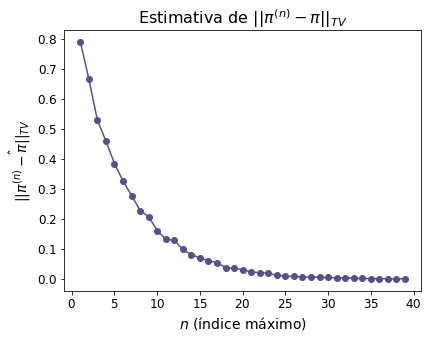

In [32]:
plt.plot(n_iter_range, tv_dist_range, 'o-', color=colors[1])
plt.title(r"Estimativa de $||\pi^{(n)}-\pi||_{TV}$")
plt.xlabel(r"$n$ (índice máximo)")
plt.ylabel(r"$\hat{||\pi^{(n)}-\pi||_{TV}}$")
plt.savefig("../figures/l4/tv-dist-estimate.pdf", bbox_inches='tight')
plt.show()

### Letra e)

**Estimativa da função de distribuição marginal**

 
Simulamos até `n_iter`. Obtemos o estado final da cadeia. Realizamos esse procedimento para `n_chains` realizações destas cadeias. A estimativa da distribuição marginal é a proporção de vezes em `n_chains` que a cadeia finaliza num determinado estado.

In [33]:
def estimate_marginal_dist(n_chains=10000, n_iter=100):
    x_n_final_state = np.zeros(n_chains)
    xp_n_final_state = np.zeros(n_chains)
    for i in range(n_chains):
        u = np.random.random(size=n_iter)
        up = np.random.random(size=n_iter)
        x_n = simulate(u, init_function_pi0, update_function)
        xp_n = simulate(up, init_function_pi, update_function)
        x_n_final_state[i] = x_n[-1]
        xp_n_final_state[i] = xp_n[-1]   
    x_n_pi_final_state = np.unique(x_n_final_state, return_counts=True)[1]/n_chains
    xp_n_pi_final_state = np.unique(xp_n_final_state, return_counts=True)[1]/n_chains
    return x_n_pi_final_state, xp_n_pi_final_state

In [34]:
final_xn, final_xp_n = estimate_marginal_dist()

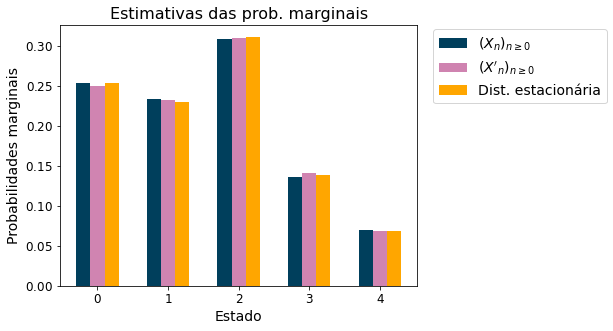

In [35]:
plt.bar(S, final_xn, color=colors[0], width=0.2, label=r"$(X_n)_{n \geq 0}$")
plt.bar(S+0.2, final_xp_n, color=colors[2], alpha=0.7, width=0.2, label=r"$({X'}_n)_{n \geq 0}$")
plt.bar(S+0.4, pi, color=colors[-1], width=0.2, label="Dist. estacionária")
plt.title("Estimativas das prob. marginais")
plt.xticks([i + 0.2 for i in S], S)
plt.xlabel("Estado")
plt.ylabel("Probabilidades marginais")
plt.legend(bbox_to_anchor=(1.55, 1.01))
plt.savefig("../figures/l4/dist-marginal.pdf", bbox_inches='tight')
plt.show()